<a href="https://colab.research.google.com/github/marcvonrohr/machine_learning/blob/main/lab_5/lab_05_stock-price%5Bextra%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align='center' style='max-width: 1000px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/banner.png?raw=1'>

<img align='right' style='max-width: 200px; height: auto' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/hsg_logo.png?raw=1'>

##  Lab 05 - Long Short-Term Memory (LSTM) Neural Networks (Stock Price Prediction)

Machine Learning, University of St. Gallen, Spring Term 2025

The lab environment is based on Jupyter Notebooks (https://jupyter.org), which allow to perform a variety of statistical evaluations and data analyses.

In this lab, we will learn how to apply another type of deep learning technique referred to as **Long Short-Term Memory (LSTM)** neural networks. Unlike standard feedforward neural networks, LSTMs encompass feedback connections that make it a "general-purpose computer". LSTMs are designed to process not only a single data point (such as images), but also entire sequences of data, e.g., such as speech, video, or financial time series.


We will again use the functionality of the `PyTorch` library to implement and train an **LSTM based neural network**. The network will be trained on the historic daily (in-sample) returns of an exemplary financial stock. Once the network is trained, we will use the learned model to predict future (out-of-sample) returns. Finally, we will convert the predictions into tradeable signals and the backtest the signals accordingly.

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab.

<img align='center' style='max-width: 700px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/process.png?raw=1'>

## 1. Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Long Short-Term Memory (LSTM) Neural Networks**.
> 2. Know how to **implement and to train an LSTM** to learn a model of financial time-series data.
> 3. Understand how to apply such a learned model to **predict future data points of a time-series**.
> 4. Know how to **interpret the model's prediction results** and backtest the predictions.

Before we start let's watch a motivational video:

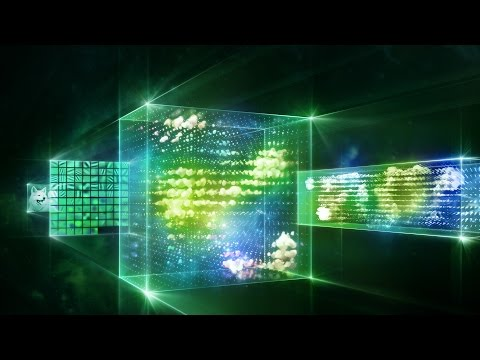

In [1]:
from IPython.display import YouTubeVideo
# Nvidia GTC 2016: "The Deep Learning Revolution" Opening in Keynote
YouTubeVideo('Dy0hJWltsyE', width=800, height=400)

## 2. Setup of the Jupyter Notebook Environment

Suppress potential warnings:

In [2]:
import warnings
warnings.filterwarnings('ignore')

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Sklearn`, `Matplotlib`, `Seaborn`, `BT` and a few utility libraries throughout the lab:

In [3]:
# import python data science and utility libraries
import os, itertools, io, urllib
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Import the backtesting library:

In [5]:
!pip install bt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.1 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.2.1 which is incompatible.


In [6]:
import bt as bt # library to backtest trading signals

Import the Python machine / deep learning libraries:

In [7]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import Python plotting libraries and set general plotting parameters:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Apply seaborn style to matplotlib plots
sns.set()
# Or  sns.set_style('darkgrid') or any other seaborn style
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Enable notebook matplotlib inline plotting:

In [10]:
%matplotlib inline

Create notebook folder structure to store the data as well as the trained neural network models:

In [11]:
# create the data sub-directory
data_directory = './data_lstm'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './models_lstm'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set random seed value to obtain reproducable results:

In [12]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Enable GPU computing by setting the `device` flag and init a `CUDA` seed:

In [13]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] notebook with \'{}\' computation enabled'.format(str(now), str(device)))

[LOG 20250324-14:35:48] notebook with 'cpu' computation enabled


## 3. Dataset Download and Data Assessment

In this section of the lab notebook we will download and access historic daily stock market data ranging from **01/01/2000** to **31/12/2017** of the **"International Business Machines" (IBM)** corporation (ticker symbol: "IBM"). Thereby, we will utilize the `datareader` of the `Pandas` library that provides the ability to interface the `Yahoo` finance API.

To start the data download, let's specify the start and end date of the stock market data download:

In [14]:
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2017, 12, 31)

Download the daily "International Business Machines" (IBM) stock market data:

In [22]:
# Download the daily "International Business Machines" (IBM) stock market data using yfinance:
import yfinance as yf
stock_data = yf.download('IBM', start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [23]:
#stock_data = dr.data.DataReader('IBM', data_source='yahoo', start=start_date, end=end_date)

AttributeError: 'NoneType' object has no attribute 'group'

Inspect the top 10 records of the retreived IBM stock market data:

In [24]:
stock_data.head(10)

Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
Date,,,,,
2000-01-03,58.507263,58.507263,56.426728,56.710435,10823694
2000-01-04,56.521282,57.750692,55.922340,57.498505,8606279
2000-01-05,58.507263,60.398664,56.552821,56.962622,13318927
2000-01-06,57.498508,59.988848,57.246322,59.515998,8338607
2000-01-07,57.246323,59.484475,55.796251,59.137719,12402108
2000-01-10,59.516003,60.209514,58.192024,59.137722,8933363
2000-01-11,60.020386,61.092178,58.822500,59.452967,8235472
2000-01-12,60.272549,61.533478,59.642082,60.335593,7116775


Let's also evaluate the data quality of the download by creating a set of summary statistics of the retrieved data:

In [25]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
count,4528.000000,4528.000000,4528.000000,4528.000000,4.528000e+03
mean,73.713872,74.329745,73.074413,73.671456,6.570122e+06
std,27.888401,27.954389,27.813955,27.883665,3.466025e+06
min,28.196676,29.031260,27.653937,27.981626,1.074765e+06
25%,48.191554,48.709709,47.710277,48.175803,4.208686e+06
50%,63.553341,64.375510,62.935732,63.520911,5.758858e+06
75%,101.591293,102.377381,100.966943,101.592430,7.995572e+06
max,128.056091,128.115440,127.165943,127.806872,4.310284e+07


Visually inspect the daily closing prices of the "International Business Machines" (IBM) stock market data:

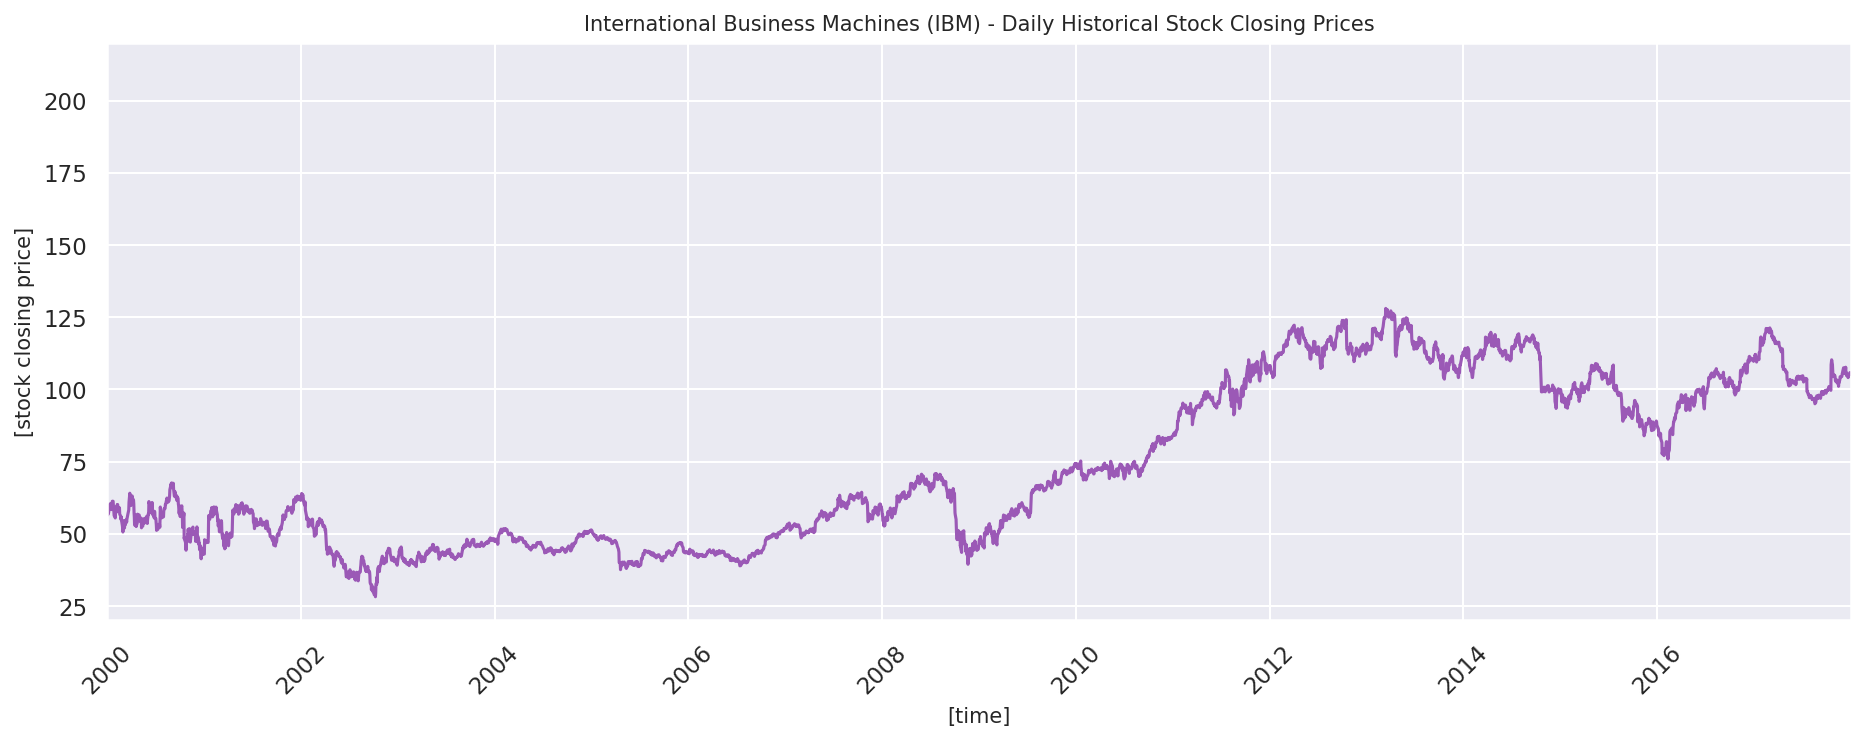

In [26]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.plot(stock_data.index, stock_data['Close'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set x-axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])

# set y-axis labels and limits
ax.set_ylabel('[stock closing price]', fontsize=10)
ax.set_ylim(20, 220)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

Save the obtained and validated stock market data to the local data directory:

In [27]:
# save retrieved data to local data directory
stock_data.to_csv(os.path.join(data_directory, 'ibm_data_2010_2017_daily.csv'), sep=';', encoding='utf-8')

## 4. Dataset Pre-Processing

In this section, we will obtain daily returns of the retrieved daily closing prices. Also, we will convert the time-series of daily returns into a set of sequences $s$ of $n$ time steps respectively. The created sequences will then be used to learn a model using an Long Short-Term Memory neural network.

### 4.1 Weekend and Holiday Padding

Let's always forward propagate the last valid available price information observation to the next available valid price information using the Panda's `reindex()` function. This in order to also obtain market price information of weekend's and holidays:

In [28]:
# fill weekends and holidays
stock_data = stock_data.reindex(index=pd.date_range(stock_data.index.min(), stock_data.index.max()), method='ffill')

Inspect the padded stock market data of the "International Business Machines" (IBM) stock:

In [29]:
stock_data.head(10)

Price,Close,High,Low,Open,Volume
Ticker,IBM,IBM,IBM,IBM,IBM
2000-01-03,58.507263,58.507263,56.426728,56.710435,10823694
2000-01-04,56.521282,57.750692,55.922340,57.498505,8606279
2000-01-05,58.507263,60.398664,56.552821,56.962622,13318927
2000-01-06,57.498508,59.988848,57.246322,59.515998,8338607
2000-01-07,57.246323,59.484475,55.796251,59.137719,12402108
2000-01-08,57.246323,59.484475,55.796251,59.137719,12402108
2000-01-09,57.246323,59.484475,55.796251,59.137719,12402108
2000-01-10,59.516003,60.209514,58.192024,59.137722,8933363
2000-01-11,60.020386,61.092178,58.822500,59.452967,8235472


Inspect the number of records obtained after the data padding:

In [30]:
stock_data.shape

(6571, 5)

### 4.2 Daily Return Calculation

Determine the daily returns of the "International Business Machines" (IBM) daily closing prices using the Panda's `pct_change()` function:

In [31]:
stock_data['RETURN'] = stock_data['Close'].pct_change()

Inspect the daily returns of the closing prices:

In [32]:
stock_data['RETURN']

,RETURN
2000-01-03,NaN
2000-01-04,-0.033944
2000-01-05,0.035137
2000-01-06,-0.017242
2000-01-07,-0.004386
...,...
2017-12-25,0.000000
2017-12-26,0.002164
2017-12-27,0.001963
2017-12-28,0.005943


Visually inspect the obtained daily returns:

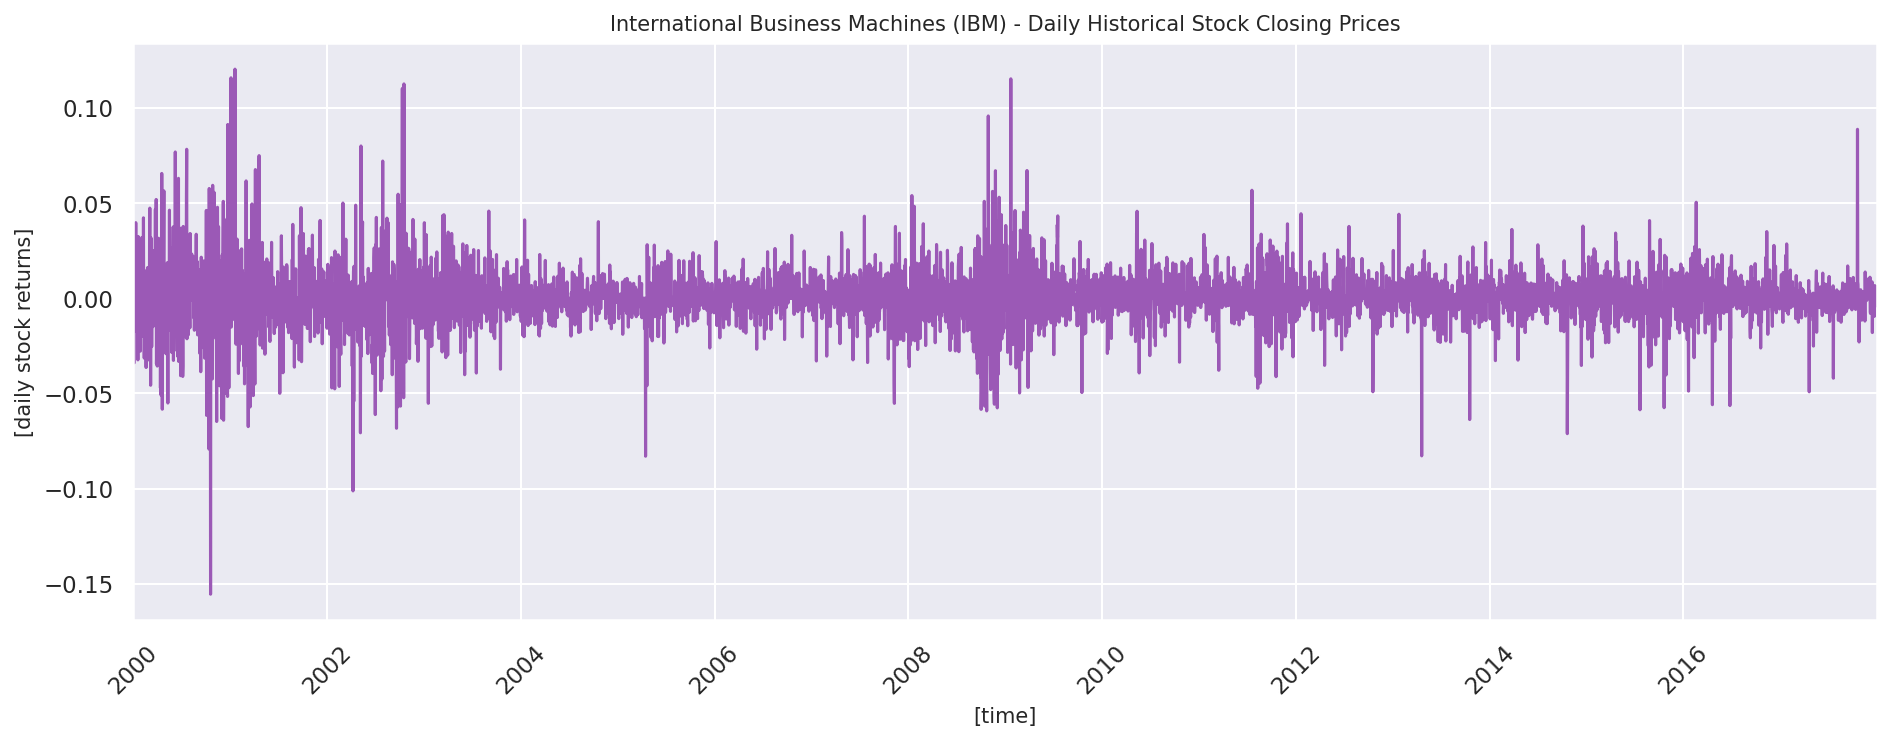

In [33]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.plot(stock_data.index, stock_data['RETURN'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])
ax.set_ylabel('[daily stock returns]', fontsize=10)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

### 4.3 Conduct Train-Test Split

To understand and evaluate the performance of any trained **supervised machine learning** model, it is good practice, to divide the dataset into a **training set** or **"in-sample"** data (the fraction of data records solely used for training purposes) and a **evaluation set** or **"out-of-sample"** data (the fraction of data records solely used for evaluation purposes). Pls. note, the **evaluation set** will never be shown to the model as part of the training process.

<img align='center' style='max-width: 500px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/traintestsplit.png?raw=1'>

We set the split fraction of training sequences to **90%** of the total number of obtained sequences:

In [34]:
split_fraction = 0.9
split_row = int(stock_data.shape[0] * split_fraction)

Split obtained returns into training ("in-sample") returns $r^{i}_{train}$ and validation ("out-of-sample") returns $r^{i}_{valid}$:

In [35]:
train_stock_data = stock_data.iloc[:split_row]
valid_stock_data = stock_data.iloc[split_row:]

Visually inspect the obtained train and validation stock returns:

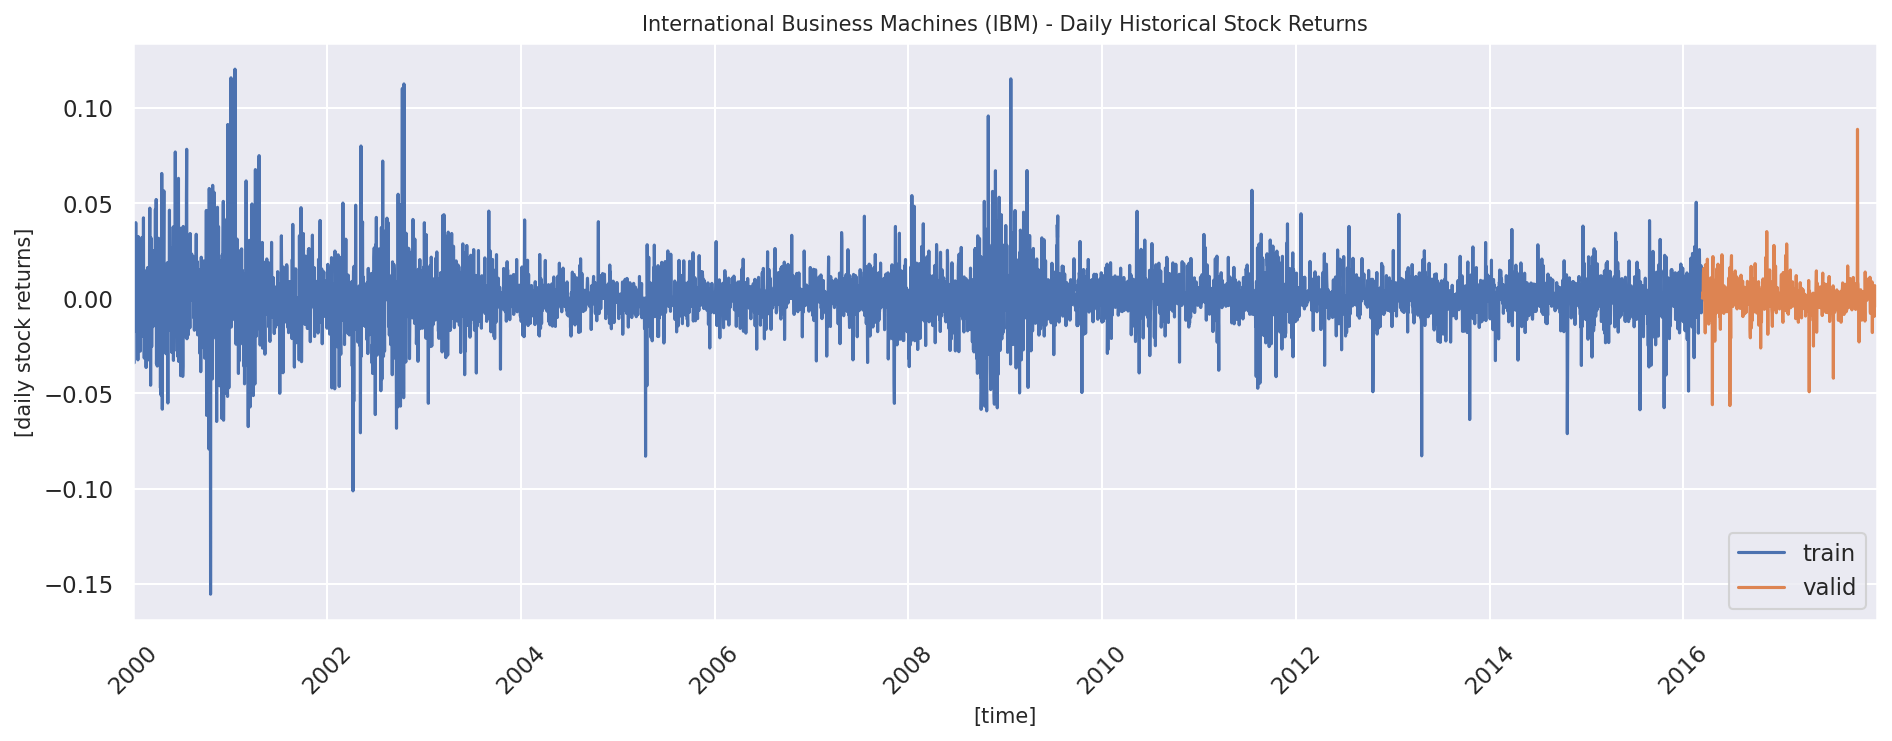

In [36]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily stock returns
ax.plot(stock_data.index[:split_row,], train_stock_data['RETURN'], c='C0', label='train')
ax.plot(stock_data.index[split_row:,], valid_stock_data['RETURN'], c='C1', label='valid')

# rotate x-labels 45 degree angle
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])
ax.set_ylabel('[daily stock returns]', fontsize=10)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Returns', fontsize=10);

Determine count (shape) of daily return train sequences $r^{i}_{train}$:

In [37]:
train_stock_data.shape

(5913, 6)

Determine count (shape) of daily return train sequences $r^{i}_{valid}$:

In [38]:
valid_stock_data.shape

(658, 6)

### 4.4 Transform into Sequences

In the following, we determine the number of return time-steps $n$ each individual sequence $s^{i}$ should be comprised of. Each sequence is thereby determined by the number of predictor (return) time-steps $t$ and the prediction (return) horizon $h = t+1$.

<img align='center' style='max-width: 500px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/timesteps.png?raw=1'>

In this example, we will set the number of predictor (return) time-steps to $t$=4. This indicates that the input sequence of each sample is a vector of 4 sequential daily stock returns (pls. note, the choice of $t$=4 is arbitrary and should be selected through experimentation). Furthermore, we set the predicted return horizon to 1, which specifies that we aim to forecast a single future time-step.

In [39]:
time_steps = 4 # number of predictor timesteps
horizon = 1 # number of timesteps to be predicted
sequence_length = time_steps + horizon # determine sequence length

Next, we extract the sequences $s^i$ of 5 time-steps.

Thereby, we will step-wise iterate ("rolling window") over the entire sequence of daily stock returns $r_i$. In each iteration step, we extract an individual sequence of stock returns consisting of $n$ time-steps. The extracted individual sequences of daily closing prices are then collected in a single data frame.

<img align='center' style='max-width: 900px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/sequences.png?raw=1'>

Determine the max number of training ("in-sample") sequences:

In [40]:
# determine max train index
max_train_index = ((train_stock_data.shape[0] // sequence_length) - 1) * sequence_length

Extract individual training sequences of length $5$ from the obtained daily returns:

In [41]:
# iterate over the distinct daily returns of the training dataset
for i in range(1, max_train_index):

    # case: initial sequence
    if i == 1:

        # convert to numpy array and collect sequence of timesteps and daily returns
        train_stock_sequence_data_date = np.array(train_stock_data.index[i:i + sequence_length].T)
        train_stock_sequence_data = np.array(train_stock_data['RETURN'][i:i + sequence_length].T)

    # case: non-initial sequence
    else:

        # convert to numpy array and collect sequence of timesteps and daily returns
        train_stock_sequence_data_date = np.vstack((train_stock_sequence_data_date, np.array(train_stock_data.index[i:i + sequence_length].T)))
        train_stock_sequence_data = np.vstack((train_stock_sequence_data, np.array(train_stock_data['RETURN'][i:i + sequence_length].T)))

Determine the total number of obtained training sequences:

In [42]:
train_stock_sequence_data.shape

(5904, 5)

Inspect the top five collected sequences of training timesteps:

In [43]:
train_stock_sequence_data_date[0:5,]

array([['2000-01-04T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-06T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
        '2000-01-08T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-06T00:00:00.000000000',
        '2000-01-07T00:00:00.000000000', '2000-01-08T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000'],
       ['2000-01-06T00:00:00.000000000', '2000-01-07T00:00:00.000000000',
        '2000-01-08T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-10T00:00:00.000000000'],
       ['2000-01-07T00:00:00.000000000', '2000-01-08T00:00:00.000000000',
        '2000-01-09T00:00:00.000000000', '2000-01-10T00:00:00.000000000',
        '2000-01-11T00:00:00.000000000'],
       ['2000-01-08T00:00:00.000000000', '2000-01-09T00:00:00.000000000',
        '2000-01-10T00:00:00.000000000', '2000-01-11T00:00:00.000000000',
        '2000-01-12T00:00:00.000000000']], dtype='datetime64[ns]')

Inspect the top five collected sequences of training returns $s^{i}_{train}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$:

In [44]:
train_stock_sequence_data[0:5,]

array([[-0.03394418,  0.03513687, -0.01724153, -0.00438595,  0.        ],
       [ 0.03513687, -0.01724153, -0.00438595,  0.        ,  0.        ],
       [-0.01724153, -0.00438595,  0.        ,  0.        ,  0.03964761],
       [-0.00438595,  0.        ,  0.        ,  0.03964761,  0.00847475],
       [ 0.        ,  0.        ,  0.03964761,  0.00847475,  0.00420129]])

Determine the max number of validation ("out-of-sample") sequences:

In [45]:
# determine max valid index
max_valid_index = ((valid_stock_data.shape[0] // sequence_length) - 1) * sequence_length

Extract individual validation sequences of length $5$ from the obtained daily returns:

In [46]:
# iterate over the distinct daily returns of the validation dataset
for i in range(1, max_valid_index):

    # case: initial sequence
    if i == 1:

        # convert to numpy array and collect sequence of timesteps and daily returns
        valid_stock_sequence_data_date = np.array(valid_stock_data.index[i:i + sequence_length].T)
        valid_stock_sequence_data = np.array(valid_stock_data['RETURN'][i:i + sequence_length].T)


    # case: non-initial sequence
    else:

        # convert to numpy array and collect sequence of timesteps and daily returns
        valid_stock_sequence_data_date = np.vstack((valid_stock_sequence_data_date, np.array(valid_stock_data.index[i:i + sequence_length].T)))
        valid_stock_sequence_data = np.vstack((valid_stock_sequence_data, np.array(valid_stock_data['RETURN'][i:i + sequence_length].T)))

Determine the total number of obtained validation sequences:

In [47]:
valid_stock_sequence_data.shape

(649, 5)

Inspect the top five collected sequences of validation timesteps:

In [48]:
valid_stock_sequence_data_date[0:5,]

array([['2016-03-13T00:00:00.000000000', '2016-03-14T00:00:00.000000000',
        '2016-03-15T00:00:00.000000000', '2016-03-16T00:00:00.000000000',
        '2016-03-17T00:00:00.000000000'],
       ['2016-03-14T00:00:00.000000000', '2016-03-15T00:00:00.000000000',
        '2016-03-16T00:00:00.000000000', '2016-03-17T00:00:00.000000000',
        '2016-03-18T00:00:00.000000000'],
       ['2016-03-15T00:00:00.000000000', '2016-03-16T00:00:00.000000000',
        '2016-03-17T00:00:00.000000000', '2016-03-18T00:00:00.000000000',
        '2016-03-19T00:00:00.000000000'],
       ['2016-03-16T00:00:00.000000000', '2016-03-17T00:00:00.000000000',
        '2016-03-18T00:00:00.000000000', '2016-03-19T00:00:00.000000000',
        '2016-03-20T00:00:00.000000000'],
       ['2016-03-17T00:00:00.000000000', '2016-03-18T00:00:00.000000000',
        '2016-03-19T00:00:00.000000000', '2016-03-20T00:00:00.000000000',
        '2016-03-21T00:00:00.000000000']], dtype='datetime64[ns]')

Inspect the top five collected sequences of validation returns $s^{i}_{valid}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$:

In [49]:
valid_stock_sequence_data[0:5,]

array([[0.        , 0.00295011, 0.0012606 , 0.01280068, 0.01553982],
       [0.00295011, 0.0012606 , 0.01280068, 0.01553982, 0.00034026],
       [0.0012606 , 0.01280068, 0.01553982, 0.00034026, 0.        ],
       [0.01280068, 0.01553982, 0.00034026, 0.        , 0.        ],
       [0.01553982, 0.00034026, 0.        , 0.        , 0.01046953]])

### 4.5 Conduct Input-Target Split

Before we continue the date pre-processing, let's briefly revisit how RNN's or, more specifically, LSTM based NN's can be trained to predict the next element of an input sequence. The cartoon below is derived from the "Next Word Predictor" Example that we also discussed in the course. For each **input return** $r_{i}$ of the input return training sequence $s^i$ the LSTM is supposed to learn to **predict the return** of the next time-step $\hat{r}_{i+1}$. In order to make such a future return $\hat{r}_{i+1}$ prediction the LSTM uses it's learned hidden state information $h_{i}$ as well as the current return $r_{i}$ as an input.

For each time-step the predicted return $\hat{r}_{i+1}$ is then compared to the **target return** $r_{i+1}$. The discrepancy between both is collected as a loss $\mathcal{L}$ for the distinct timesteps. The accumulation of the individual time-step losses is accumulated as the total loss of a sequence $\mathcal{L}_{All}$.

<img align='center' style='max-width: 600px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/training.png?raw=1'>

Seperate each training sequence $s^{i}$ into time-steps of input returns denoted by $s^{i}_{train, input}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$ and the time-step of the to be predicted target return denoted by $s^{i}_{train, target}=r_{t+1}$.

<img align='center' style='max-width: 700px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/sequencesplit.png?raw=1'>

In addition, we convert both the input returns as well as the target returns to PyTorch tensors:

In [50]:
train_sequences_input = torch.from_numpy(train_stock_sequence_data[:, :-1]).float()
train_sequences_target = torch.from_numpy(train_stock_sequence_data[:, 1:]).float()

Seperate each validation sequence $s^{i}$ into time-steps of input returns denoted by $s^{i}_{valid, input}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$ and the time-step of the to be predicted target return denoted by $s^{i}_{valid, target}=r_{t+1}$. In addition, we convert both the input returns as well as the target returns to PyTorch tensors:

In [51]:
valid_sequences_input = torch.from_numpy(valid_stock_sequence_data[:, :-1]).float()
valid_sequences_target = torch.from_numpy(valid_stock_sequence_data[:, 1:]).float()

To train an LSTM neural network, we tailor the dataset class provided by the PyTorch library. We overwrite the individual functions of the dataset class. So that our dataset will supply the neural network with the individual training sequences $s^{i}_{train, input}$ and corresponding targets $s^{i}_{train, target}$ throughout the training process:

In [52]:
# define daily returns dataset
class DailyReturnsDataset(data.Dataset):

    # define the class constructor
    def __init__(self, sequences, targets):

        # init sequences and corresponding targets
        self.sequences = sequences
        self.targets = targets

    # define the length method
    def __len__(self):

        # returns the number of samples
        return len(self.targets)

    # define the get item method
    def __getitem__(self, index):

        # determine single sequence and corresponding target
        sequence = self.sequences[index, :]
        target = self.targets[index, :]

        # return sequences and target
        return sequence, target

Once we have specified the daily returns dataset class we instantiate it using the new daily closing dataset using the prepared training input sequences $s^{i}_{train, input}$ and corresponding targets $s^{i}_{train, target}$:

In [53]:
train_dataset = DailyReturnsDataset(train_sequences_input, train_sequences_target)

Let's see how it works by getting the 42th sequence and its corresponding targets:

In [54]:
train_dataset.__getitem__(42)

(tensor([ 0.0092, -0.0117,  0.0086, -0.0364]),
 tensor([-0.0117,  0.0086, -0.0364,  0.0000]))

## 5. Neural Network Implementation

In this section, we will implement the LSTM architecture of the to be learned time series model. Furthermore, we will specify the loss-function, learning-rate and optimization technique used in the network training.

### 5.1. Implementation of the Network Architecture

In this section, we will implement the architecture of the LSTM neural network utilized to predict future returns of financial time series data, e.g. as in this example, the future returns of a given stock. The neural network, which we name **'LSTMNet'** consists in total of three layers. The first two layers correspond to LSTM cells, while the third layer corresponds to a fully-connected linear layer.

<img align='center' style='max-width: 400px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/lstmnet.png?raw=1'>

The general LSTM cell structure as well as the formal definition of its individual gate functions are shown in the following (not considering the bias of each layer for simplicity):

<img align='center' style='max-width: 700px' src='https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/lab_5/figures/lstmcell.png?raw=1'>

(Source: https://pytorch.org/docs/stable/nn.html)

Each LSTM layer consits of a LSTM cell exhibiting a hidden state of 51 dimensions. The third linear squeezes the 51 hidden state dimensions of the second LSTM cell into a single output dimension. The single output signal of the linear layer refers to the return of the next time-step predicted by the neural network. Please note, that the choice of the implemented architecture and network hyperparameters is arbitrary and should in a real-world scenario be evaluated and selected thoroughly through experimentation.

In [55]:
# implement the LSTMNet network architecture
class LSTMNet(nn.Module):

    # define class constructor
    def __init__(self):

        super(LSTMNet, self).__init__()

        # define lstm nn architecture
        self.lstm1 = nn.LSTMCell(1, 51)  # first lstm layer
        self.lstm2 = nn.LSTMCell(51, 51)  # second lstm layer
        self.linear = nn.Linear(51, 1)  # final linear layer

    # define network forward pass
    def forward(self, input):

        # init predictions
        predictions = []

        # init the lstm hidden states
        h_t1 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)

        # init the lstm cell states
        c_t1 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)

        # iterate over distinct time steps
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            # propagate through time step data
            h_t1, c_t1 = self.lstm1(input_t, (h_t1, c_t1))
            h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
            prediction = self.linear(h_t2)

            # collect predictions
            predictions += [prediction]

        # stack predictions
        predictions = torch.stack(predictions, 1).squeeze(2)

        # return predictions
        return predictions

Now, that we have implemented our first LSTM neural network we are ready to instantiate a model to be trained:

In [56]:
lstm_model = LSTMNet().to(device)

Once the model is initialized, we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [57]:
# print the initialized architectures
print('[LOG] LSTMNet architecture:\n\n{}\n'.format(lstm_model))

[LOG] LSTMNet architecture:

LSTMNet(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)



Looks like intended? Great! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [58]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in lstm_model.parameters():

    # collect number of parameters
    num_params += param.numel()

# print the number of model paramters
print('[LOG] Number of to be trained LSTMNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained LSTMNet model parameters: 32284.


Ok, our "simple" `LSTMNet` model already encompasses an impressive number **32'284 model parameters** to be trained.

### 5.2. Definition of the Training Loss, Learning Rate, and Optimizer

We are now good to train the network. However, prior to starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the prediction error of the true return $r_{t+1}$ and the by the model predicted return $\hat{r}_{t+1}$ at a given time-step $t+1$ of sequence $s^{i}$. In other words, for a given sequence of historic returns we aim to learn a function $f_\theta$ that is capable to predicts the return of the next timestep as faithfully as possible, as expressed by:

<center> $\hat{r}_{t+1} = f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})$. </center>

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\min_{\theta} \|r_{t+1} - f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})\|$ over all time-steps $t$ contained in the set of training sequences $s_{train}$. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ while training the neural network. In this lab we use the **'Mean Squared Error (MSE)'** loss, as denoted by:

<center> $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$, </center>

In [59]:
loss_function = nn.MSELoss().to(device)

Throughout the training process, the PyTorch library will automatically calculate the loss magnitude, compute the gradient, and update the parameters $\theta$ of the LSTM neural network. We will use the **"Adaptive Moment Estimation Optimization" (ADAM)** technique to optimize the network parameters. Furthermore, we specify a constant learning rate of $l = 1e-06$. For each training step, the optimizer will update the model parameters $\theta$ values according to the degree of prediction error (the MSE loss).

In [60]:
learning_rate = 1e-06 # set constant learning rate
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate) # define optimization technique

Now that we have successfully implemented and defined the three ANN building blocks let's take some time to review the `LSTMNet` model definition as well as the `MSE loss` function. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

## 6. Neural Network Model Training

In this section, we will train the LSTM neural network model (as implemented in the section above) using the prepared dataset of daily return sequences. Therefore, we will have a detailed look into the distinct training steps and monitor the training progress.

### 6.1. Preparing the Network Training

Let's now start to learn a model by training the NN for **5 epochs** in mini-batches of the size of **128  sequences** per batch. This implies that the whole dataset will be fed to the network **5 times** in chunks of 128 sequences yielding to **32 mini-batches** (4'068 training sequences / 128 sequences per mini-batch) per epoch:

In [61]:
# specify the training parameters
num_epochs = 200 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, lets specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [62]:
dl = dataloader.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

### 6.2. Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed as follows:

>1. do a forward pass through the LSTMNet network,
>2. compute the mean-squared prediction error $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$,
>3. do a backward pass through the LSTMNet network, and
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training the LSTM model we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the mean prediction performance over all mini-batches in each training epoch. Based on this evaluation we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:

>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [63]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
lstm_model.train()

# init the best loss
best_loss = 100.00

# iterate over epochs
for epoch in range(0, num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over mini-batches
    for sequence_batch, target_batch in dl:

        # push mini-batch data to computation device
        sequence_batch = sequence_batch.to(device)
        target_batch = target_batch.to(device)

        # predict sequence output
        prediction_batch = lstm_model(sequence_batch)

        # calculate batch loss
        batch_loss = loss_function(prediction_batch, target_batch)

        # run backward gradient calculation
        batch_loss.backward()

        # update network parameters
        optimizer.step()

        # collect mini-batch loss
        train_mini_batch_losses.append(batch_loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = dt.datetime.utcnow().strftime('%Y%m%d-%H:%M:%S')
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

    # print epoch and save models
    if epoch % 10 == 0 and epoch > 0:

        # case: new best model trained
        if train_epoch_loss < best_loss:

            # store new best model
            model_name = 'best_lstm_model_{}.pth'.format(str(epoch))
            torch.save(lstm_model.state_dict(), os.path.join(models_directory, model_name))

            # update best loss
            best_loss = train_epoch_loss

            # print epoch loss
            now = dt.datetime.utcnow().strftime('%Y%m%d-%H:%M:%S')
            print('[LOG {}] epoch: {} new best train-loss: {} found'.format(str(now), str(epoch), str(train_epoch_loss)))


[LOG 20250324-14:39:02] epoch: 0 train-loss: 0.003599912626668811
[LOG 20250324-14:39:03] epoch: 1 train-loss: 0.0035255892608473277
[LOG 20250324-14:39:03] epoch: 2 train-loss: 0.003432909953110713
[LOG 20250324-14:39:04] epoch: 3 train-loss: 0.003348443681929023
[LOG 20250324-14:39:05] epoch: 4 train-loss: 0.0032558637582003436
[LOG 20250324-14:39:05] epoch: 5 train-loss: 0.003167268017584339
[LOG 20250324-14:39:06] epoch: 6 train-loss: 0.003084069955103258
[LOG 20250324-14:39:06] epoch: 7 train-loss: 0.0029930453697972477
[LOG 20250324-14:39:07] epoch: 8 train-loss: 0.0029145683399698836
[LOG 20250324-14:39:07] epoch: 9 train-loss: 0.0028272866608297573
[LOG 20250324-14:39:08] epoch: 10 train-loss: 0.0027551740318774542
[LOG 20250324-14:39:08] epoch: 10 new best train-loss: 0.0027551740318774542 found
[LOG 20250324-14:39:09] epoch: 11 train-loss: 0.0026706614075823034
[LOG 20250324-14:39:09] epoch: 12 train-loss: 0.002605164215523512
[LOG 20250324-14:39:10] epoch: 13 train-loss: 0.0

Upon successful training let's visualize and inspect the training loss per epoch:

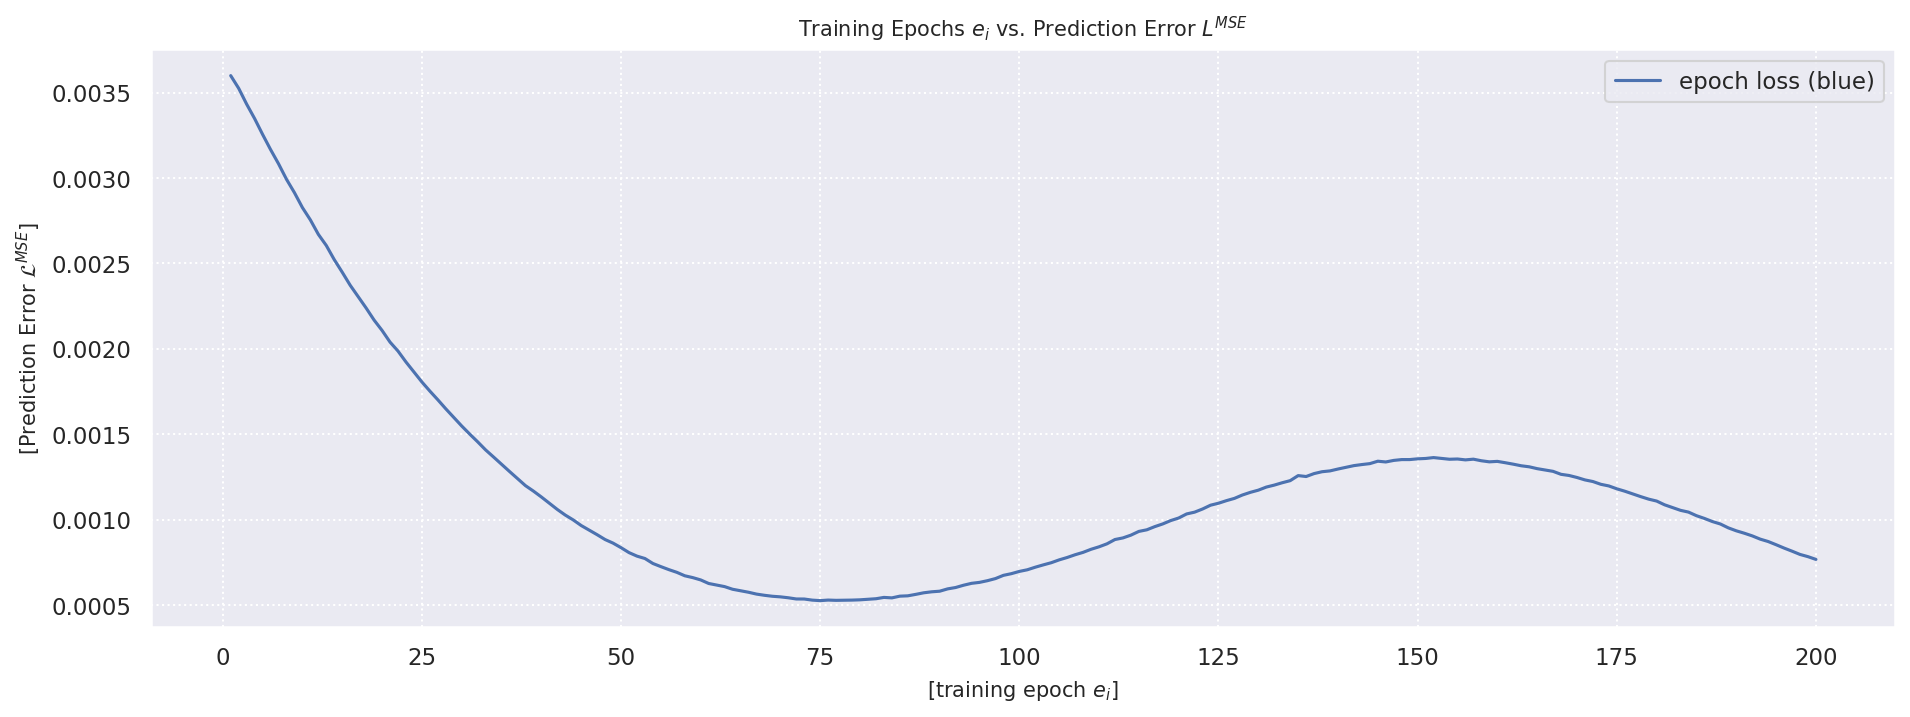

In [64]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[training epoch $e_i$]', fontsize=10)
ax.set_ylabel('[Prediction Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Prediction Error $L^{MSE}$', fontsize=10);

Ok, fantastic. The training error is nicely going down. We could train the network a couple more epochs until the error converges. But let's stay with the 200 training epochs for now and continue with evaluating our trained model.

## 7. Neural Network Model Evaluation

In this section, we will conduct a visual comparison of the predicted daily returns to the actual ('true') daily returns. The comparison will encompass the daily returns of the in-sample time period as well as the returns of the out-of-sample time period.

### 7.1. In-Sample Evaluation

Before starting our evaluation, let's load the best performing model or an already pre-trained model (as done below). Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load one of the (hopefully well-performing) snapshots saved.

In [71]:
# init the pre-trained model architecture
lstm_model_pretrained = LSTMNet().to(device)

# restore pretrained model checkpoint

# define remote model path
github_model_path = 'https://github.com/HSG-AIML-Teaching/ML2025-Lab/raw/refs/heads/main/lab_5/models_lstm/'

# define remote model name
lstm_model_name_pretrained = 'best_lstm_model_30000.pth'

# Read stored model from the remote location
lstm_bytes = urllib.request.urlopen(os.path.join(github_model_path, lstm_model_name_pretrained))

# Load tensor from io.BytesIO object
lstm_buffer = io.BytesIO(lstm_bytes.read())

# load trained models
lstm_model_pretrained.load_state_dict(torch.load(lstm_buffer, map_location='cpu', weights_only=False))

<All keys matched successfully>

Let's inspect if the model was loaded successfully:

In [72]:
# set model in evaluation mode
lstm_model_pretrained.eval()

LSTMNet(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

Use the pre-trained model to determine the daily return predictions of the **in-sample** sequence population:

In [73]:
# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    train_predictions = lstm_model_pretrained(train_sequences_input.to(device))

    # collect prediction batch results
    train_predictions_list = train_predictions.cpu().detach().numpy()[:, -1].tolist()

    # collect target batch results
    train_targets_list = train_sequences_target.numpy()[:, -1].tolist()

Plot the pre-trained `LSTMNet` daily **in-sample** predictions vs. the target ("ground-truth") daily returns:

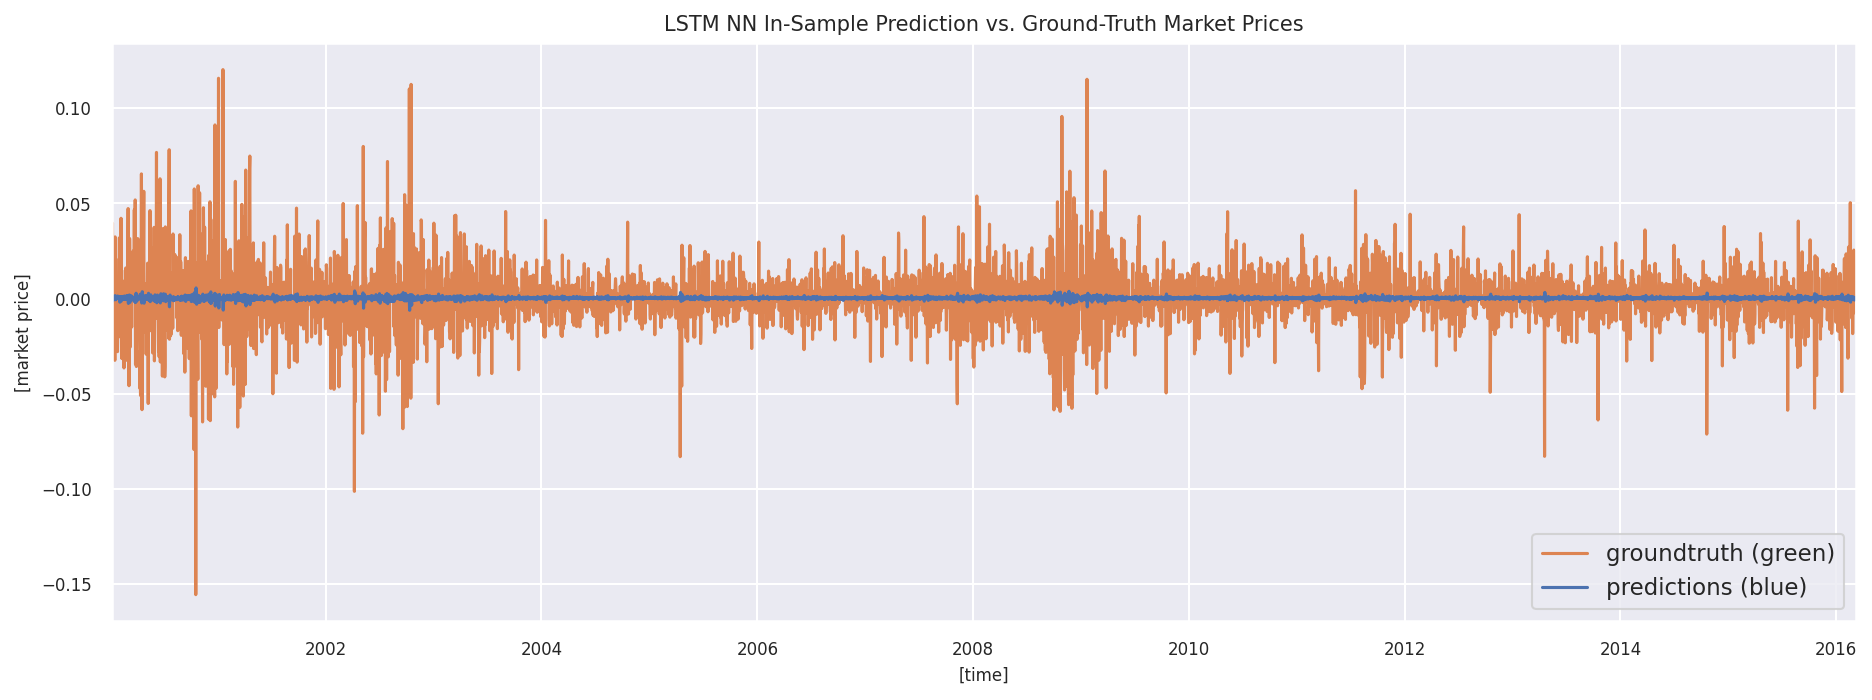

In [75]:
# plot the prediction results
sns.set()
#plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi']= 150

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(train_stock_sequence_data_date[:, -1], train_targets_list, color='C1', label='groundtruth (green)')
ax.plot(train_stock_sequence_data_date[:, -1], train_predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(train_stock_sequence_data_date[:, -1].min(), train_stock_sequence_data_date[:, -1].max())

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('LSTM NN In-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)

# set axis labels
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)

# set axis ticks fontsize
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

### 7.2. Out-of-Sample Evaluation

Use the pre-trained model to determine the daily return predictions of the **out-of-sample** sequence population:

In [76]:
# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    valid_predictions = lstm_model_pretrained(valid_sequences_input.to(device))

    # collect prediction batch results
    valid_predictions_list = valid_predictions.cpu().detach().numpy()[:, -1].tolist()

    # collect target batch results
    valid_targets_list = valid_sequences_target.numpy()[:, -1].tolist()

Plot the pre-trained `LSTMNet` daily **out-of-sample** predictions vs. the target ("ground-truth") daily returns:

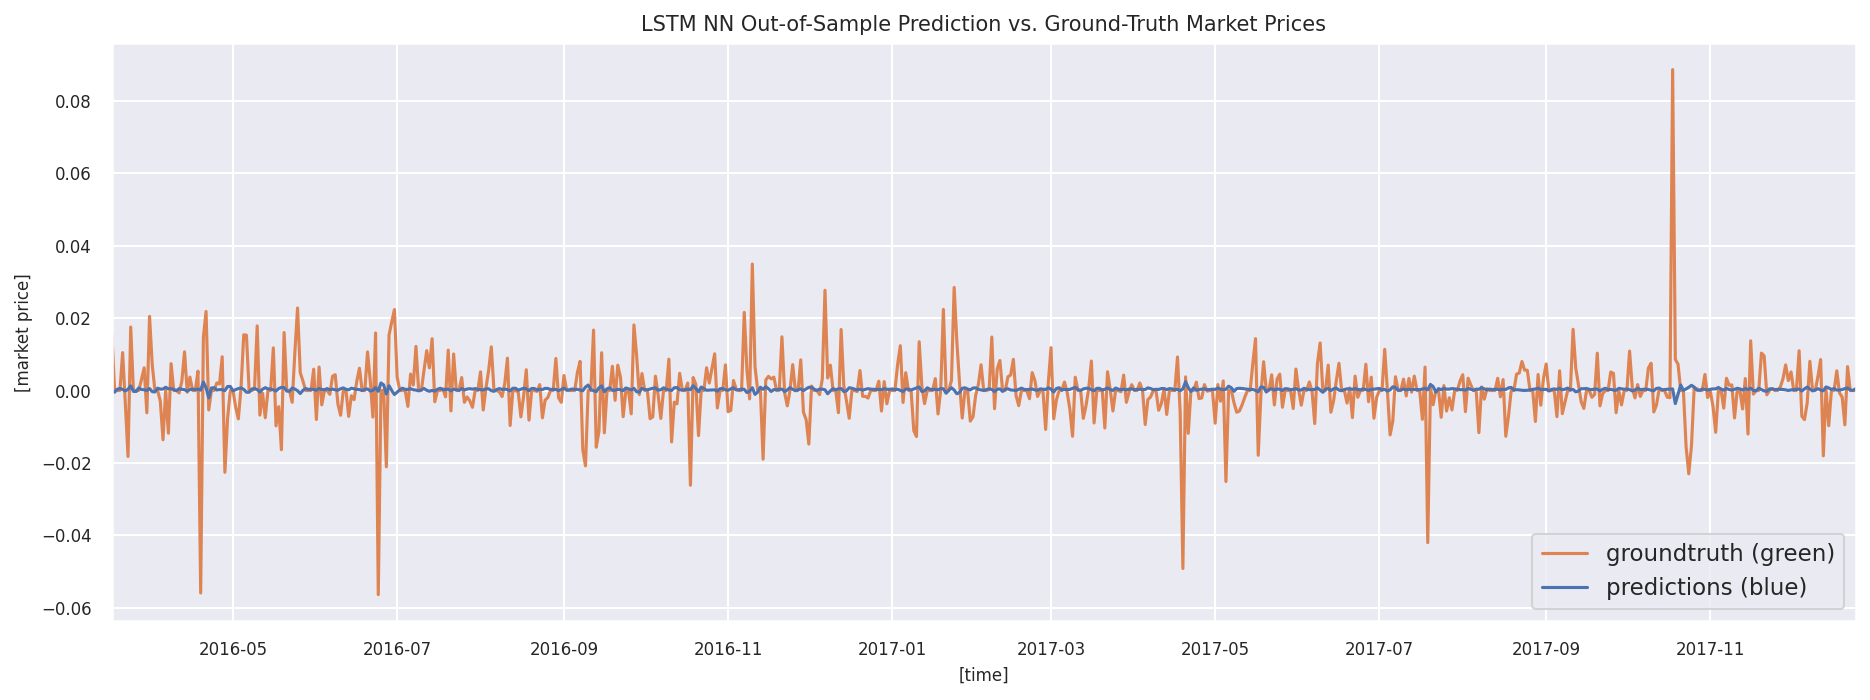

In [80]:
# plot the prediction results
sns.set()
#plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi']= 150

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(valid_stock_sequence_data_date[:, -1], valid_targets_list, color='C1', label='groundtruth (green)')
ax.plot(valid_stock_sequence_data_date[:, -1], valid_predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(valid_stock_sequence_data_date[:, -1].min(), valid_stock_sequence_data_date[:, -1].max())

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('LSTM NN Out-of-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)

# set axis labels
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)

# set axis ticks fontsize
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

## 8. Neural Network Model Backtesting

In this section, we will backtest the python `bt` library. Python `bt` is a flexible, backtest framework that can be used to test quantitative trading strategies. In general, backtesting is the process of testing a strategy over a given data set (more details about the `bt` library can be found via: https://pmorissette.github.io/bt/).

In order to test the predictions derived from the LSTM model we will view its predictions $\hat{r}_{i+1}$ as trade signals $\phi$. Thereby, we will interpret any positive future return prediction $r_{t+1} > 0.0$ of a sequence $s^i$ as a "long" (buy) signal. Likewise, we will interpret any negative future return prediction $r_{t+1} < 0.0$ of a sequence $s$ as a "short" (sell) signal.

### 8.1. LSTM Trading Signal Preparation

Let's start by converting the out-of-sample model predictions into a trading signal, as described above. Therefore, we first convert the obtained predictions into a data frame that contains (1) the **date of the predicted returns** as well as (2) the **predicted returns $r_{t+1}$** itself:

In [81]:
signal_data = pd.DataFrame(valid_predictions_list, columns=['PREDICTIONS'], index=valid_stock_sequence_data_date[:, -1])

Furthermore, let's briefly ensure the successful conversion by inspecting the top 10 rows of the created data frame:

In [82]:
signal_data.head(10)

,PREDICTIONS
2016-03-17,-0.000161
2016-03-18,-0.000474
2016-03-19,0.000342
2016-03-20,0.000569
2016-03-21,0.000268
2016-03-22,-0.000109
2016-03-23,0.000318
2016-03-24,0.001278
2016-03-25,-0.000242
2016-03-26,-0.000273


Now, let's derive a trading signal from the converted predictions. As already described, we will generate the trading signal $\phi$ according to the following function:

<center>
$
\\
\phi(\hat{r}_{t+1})=
\begin{cases}
1.0, & for & \hat{r}_{t+1} > 0.0\\
-1.0, & for & \hat{r}_{t+1} < 0.0\\
\end{cases}
$
</center>

where $\hat{r}_{t+1}$ denotes a by the model predicted future return at time $t+1$.

In [83]:
signal_data['SIGNAL'] = np.where(signal_data['PREDICTIONS'] > 0.0, 1.0, -1.0)

Let's inspect the top 10 rows of the prepared trading signals:

In [84]:
signal_data.head(10)

,PREDICTIONS,SIGNAL
2016-03-17,-0.000161,-1.0
2016-03-18,-0.000474,-1.0
2016-03-19,0.000342,1.0
2016-03-20,0.000569,1.0
2016-03-21,0.000268,1.0
2016-03-22,-0.000109,-1.0
2016-03-23,0.000318,1.0
2016-03-24,0.001278,1.0
2016-03-25,-0.000242,-1.0
2016-03-26,-0.000273,-1.0


Let's now offset the prepared trading signal by a single day $t-1$. Thereby, we rebalance our stock positions one day prior and according to the closing price predicted by the `LSTMNet` model. As a result we will be able to anticipate the model's future closing price prediction for a particular day $t$:

In [85]:
signal_data = signal_data.set_index(signal_data['SIGNAL'].index - pd.DateOffset(1))

Let's inspect the top 10 rows of the prepared and offset trading signals:

In [86]:
signal_data.head(10)

,PREDICTIONS,SIGNAL
2016-03-16,-0.000161,-1.0
2016-03-17,-0.000474,-1.0
2016-03-18,0.000342,1.0
2016-03-19,0.000569,1.0
2016-03-20,0.000268,1.0
2016-03-21,-0.000109,-1.0
2016-03-22,0.000318,1.0
2016-03-23,0.001278,1.0
2016-03-24,-0.000242,-1.0
2016-03-25,-0.000273,-1.0


Visualize the predicted and prepared trading signals of the `LSTMNet` model:

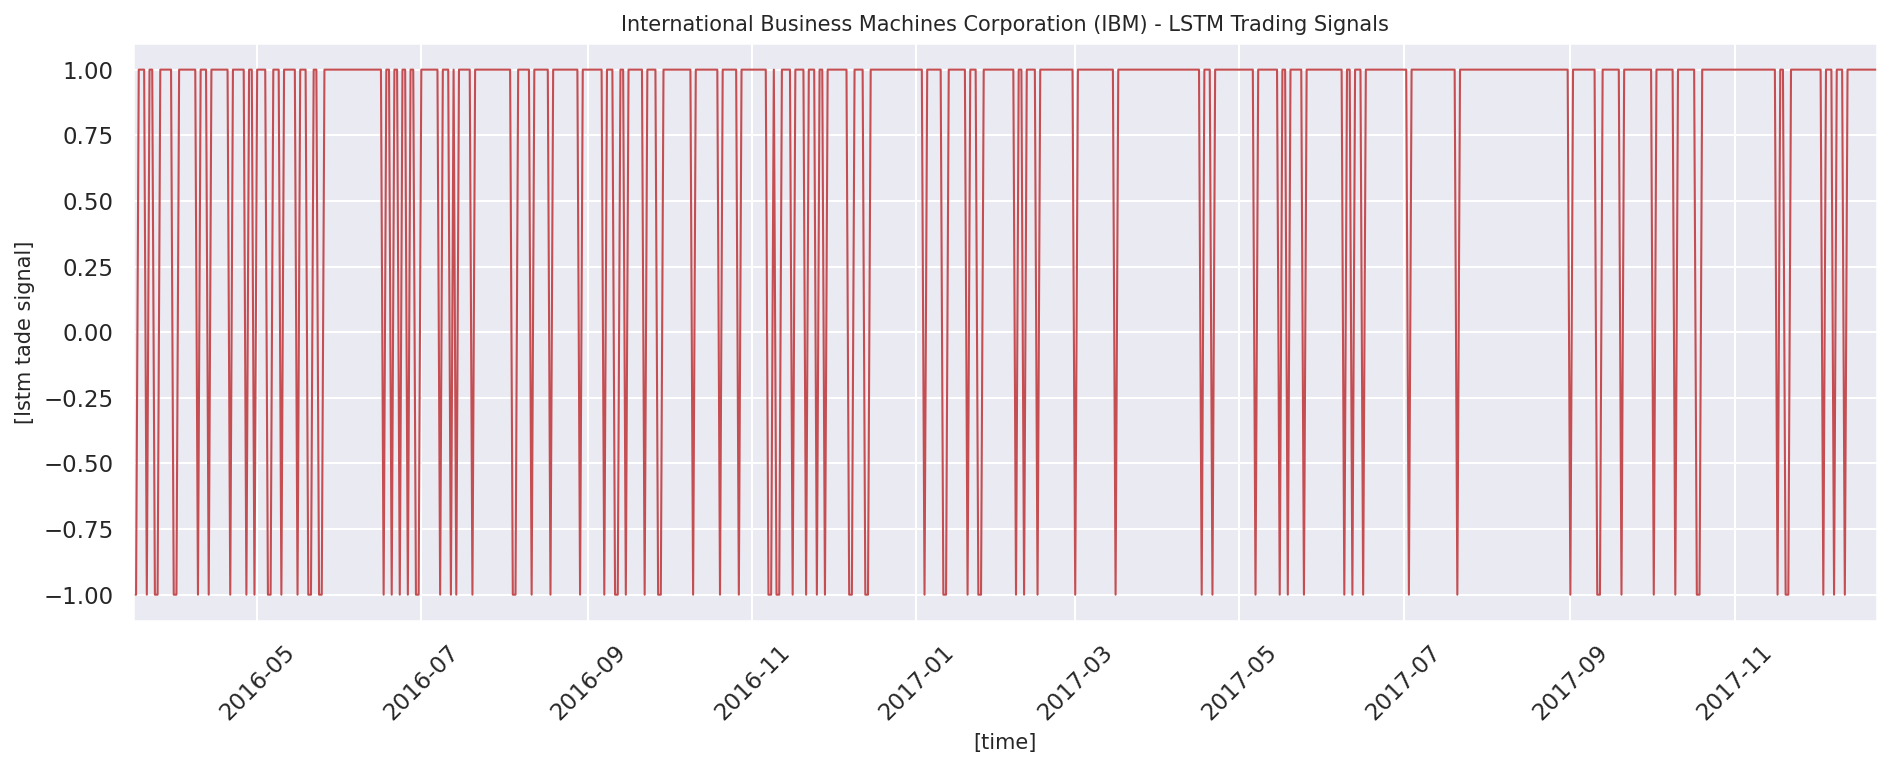

In [87]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(signal_data['SIGNAL'], lw=1.0, color='C3', label='LSTM trade signals')

# set axis ranges
ax.set_xlim([signal_data.index[0], signal_data.index[-1]])
ax.set_ylim([-1.1, 1.1])

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[lstm tade signal]', fontsize=10)

# rotate x-axis ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - LSTM Trading Signals', fontsize=10);

Determine the number of trade signal changes (trades to be executed) within the out-of-sample timeframe **03/2016** until **12/2017**, resulting in a total in-sample timeframe of approx. **21 months** (9 + 12):

In [88]:
# determine number of signal changes
len(list(itertools.groupby(signal_data['SIGNAL'], lambda x: x > 0)))

148

On average around **7** signal changes (trades) per month (148 signal changes / 21 months) within the out-of-sample time period.

### 8.2. Stock Market Data Preparation

Now, let's prepare the daily closing prices so that they can be utilized in the backtest:

In [89]:
stock_market_data = pd.DataFrame(stock_data['Close'])
stock_market_data = stock_market_data.rename(columns={'Close': 'PRICE'})
stock_market_data = stock_market_data.set_index(pd.to_datetime(stock_data.index))

Let's inspect the top 5 rows of the prepared closing prices:

In [90]:
stock_market_data.head(5)

Ticker,IBM
2000-01-03,58.507263
2000-01-04,56.521282
2000-01-05,58.507263
2000-01-06,57.498508
2000-01-07,57.246323


Sub-sample the prepared daily closing prices to the out-of-sample time period:

In [91]:
stock_market_data = stock_market_data[stock_market_data.index >= signal_data.index[0]]
stock_market_data = stock_market_data[stock_market_data.index <= signal_data.index[-1]]

Let's inspect the top 5 rows of the prepared closing prices:

In [92]:
stock_market_data.head(5)

Ticker,IBM
2016-03-16,93.196030
2016-03-17,94.644279
2016-03-18,94.676483
2016-03-19,94.676483
2016-03-20,94.676483


Visualize the out-of-sample daily closing prices:

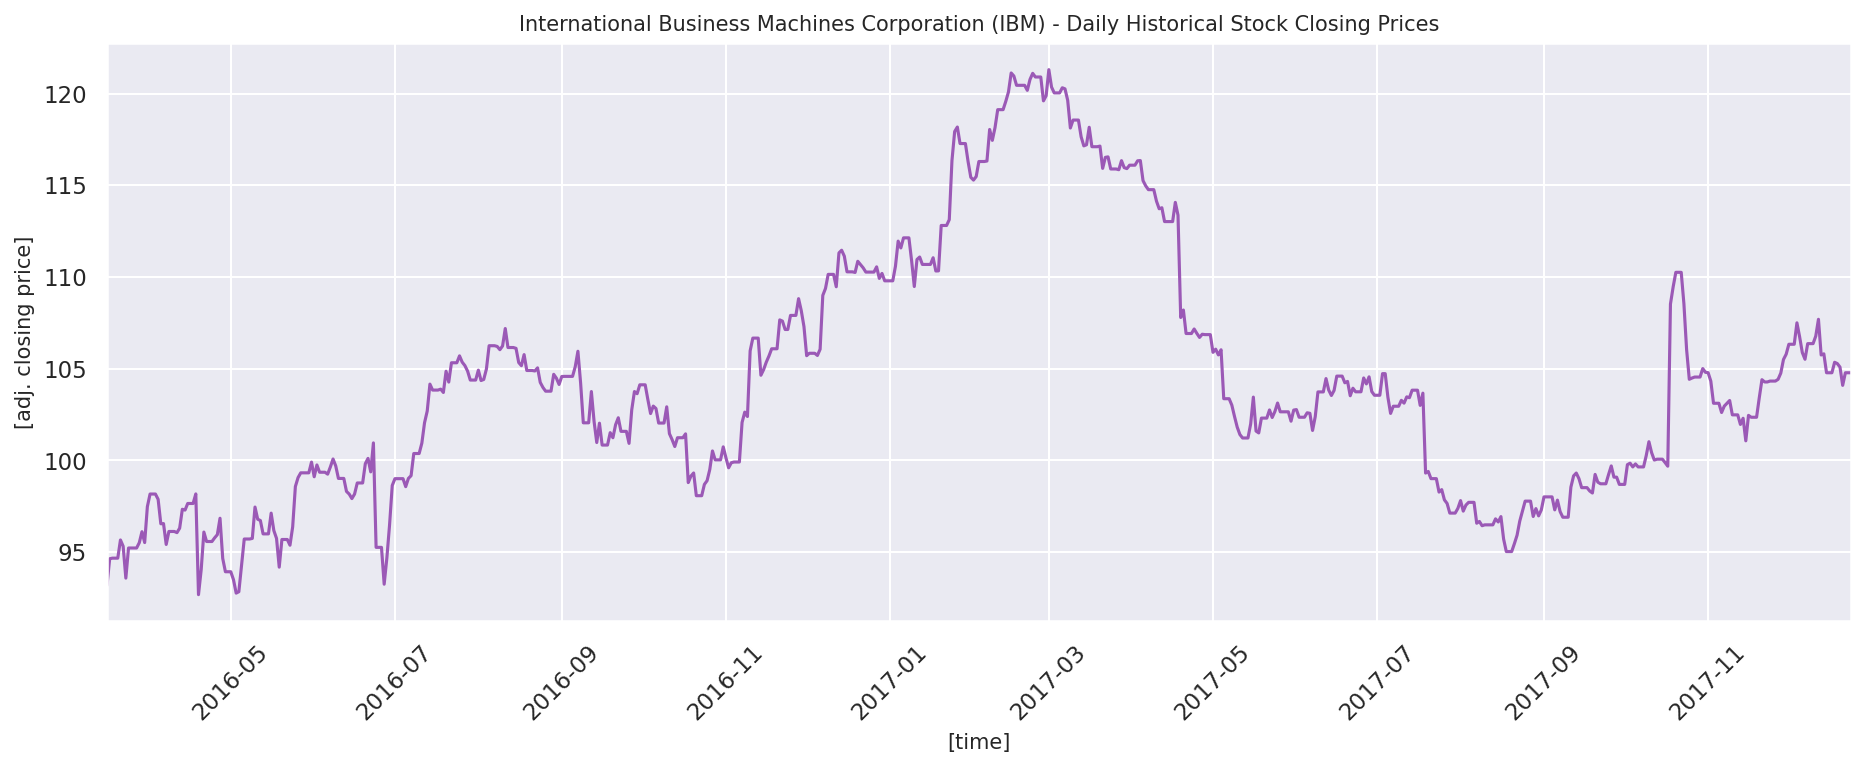

In [98]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# Assuming stock_data contains the original DataFrame with 'Close' column
stock_market_data = stock_data[(stock_data.index >= signal_data.index[0]) & (stock_data.index <= signal_data.index[-1])]
ax.plot(stock_market_data['Close'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[equity %]', fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([stock_market_data.index[0], stock_market_data.index[-1]])
ax.set_ylabel('[adj. closing price]', fontsize=10)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

Let's calculate the potentially gained return by the application of a simple **"buy and hold"** strategy:

In [99]:
np.abs(stock_market_data.iloc[0]['Close'] - stock_market_data.iloc[-1]['Close']) / stock_market_data.iloc[0]['Close']

,0
Ticker,
IBM,0.124309


Ok, with such a simple strategy we would have been able to yield a total return of approx. **5.32%**.

### 8.3. Backtest Preparation

Now that we have trading signals as well as the market data let's implement the LSTM based trading strategy which we name `LSTMStrategy`:

In [100]:
class LSTMStrategy(bt.Algo):

    def __init__(self, signals):

        # set class signals
        self.signals = signals

    def __call__(self, target):

        if target.now in self.signals.index[1:]:

            # get actual signal
            signal = self.signals[target.now]

            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)

        # return True since we want to move on to the next timestep
        return True

Let's instantiate our LSTM based trading strategy:

In [101]:
lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(signal_data['SIGNAL']), bt.algos.Rebalance()])

Initialize the backtest of our LSTM based trading strategy using the strategy and prepared market data:

In [102]:
backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=stock_market_data, name='stock_lstm_backtest')

In addition, let's also prepare a backtest of a "baseline" buy-and-hold trading strategy for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal at each time step of the out-of-sample time frame:

In [103]:
signal_data_base = signal_data.copy(deep=True)
signal_data_base['SIGNAL'] = 1.0

Init the buy-and-hold ("base") strategy as well as the corresponding backtest:

In [104]:
base_strategy = bt.Strategy('base', [bt.algos.SelectAll(), LSTMStrategy(signal_data_base['SIGNAL']), bt.algos.Rebalance()])
backtest_base = bt.Backtest(strategy=base_strategy, data=stock_market_data, name='stock_base_backtest')

### 8.4. Backtest Execution and Evaluation

Run the backtest for both trading strategies:

In [106]:
# not working or fixable
# backtest_results = bt.run(backtest_lstm, backtest_base)

Inspect the individual backtest results and performance measures:

In [107]:
# not working or fixable
# backtest_results.display()

Collect detailed backtest performance per timestep of the LSTM trading strategy:

In [108]:
# not working or fixable
# backtest_lstm_details = backtest_lstm.strategy.prices.to_frame(name='Rel. EQUITY')
# backtest_lstm_details['Abs. EQUITY'] = backtest_lstm.strategy.values # equity per timestep
# backtest_lstm_details['CASH'] = backtest_lstm.strategy.cash # cash per timestep
#backtest_lstm_details['POSITIONS'] = backtest_lstm.strategy.positions # positions per timestep
# backtest_lstm_details['FEES'] = backtest_lstm.strategy.fees # trading fees per timestep

Inspect the LSTM trading strategy backtest details:

In [109]:
# not working or fixable
# backtest_lstm_details.head(10)

Visualize the monthly returns obtained by the LSTM based trading strategy:

In [110]:
# not working or fixable
# plt.rcParams['figure.figsize'] = [15, 5]
# fig = plt.figure()
# ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
# ax = sns.heatmap(backtest_lstm.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
# ax.set_xlabel('[month]', fontsize=10)
# ax.set_ylabel('[year]', fontsize=10)

# set plot title
# ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns LSTM Strategy', fontsize=10);

Collect detailed backtest performance per timestep of the "buy-and-hold" trading strategy:

In [111]:
# not working or fixable
# backtest_base_details = backtest_base.strategy.prices.to_frame(name='Rel. EQUITY')
# backtest_base_details['Abs. EQUITY'] = backtest_base.strategy.values # equity per timestep
# backtest_base_details['CASH'] = backtest_base.strategy.cash # cash per timestep
# backtest_base_details['POSITIONS'] = backtest_base.strategy.positions # positions per timestep
# backtest_base_details['FEES'] = backtest_base.strategy.fees # trading fees per timestep

Inspect the "buy-and-hold" trading strategy backtest details:

In [112]:
# not working or fixable
# backtest_base_details.head(10)

Visualize the monthly returns obtained by the "buy-and-hold" trading strategy:

In [113]:
# not working or fixable
# plt.rcParams['figure.figsize'] = [15, 5]
# fig = plt.figure()
# ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
# ax = sns.heatmap(backtest_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
# ax.set_xlabel('[month]', fontsize=10)
# ax.set_ylabel('[year]', fontsize=10)

# set plot title
# ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns \'buy-and-hold\' Strategy', fontsize=10);

Visualize the equity progression of both strategies over time:

In [114]:
# not working or fixable
# plt.rcParams['figure.figsize'] = [15, 5]
# fig = plt.figure()
# ax = fig.add_subplot(111)

# ax.plot(backtest_lstm_details['Rel. EQUITY'], color='C1',lw=1.0, label='lstm strategy (green)')
# ax.plot(backtest_base_details['Rel. EQUITY'], color='C2',lw=1.0, label='base strategy (red)'# #)

# for tick in ax.get_xticklabels():
#    tick.set_rotation(45)

# set axis labels
# ax.set_xlabel('[time]', fontsize=10)
# ax.set_xlim(valid_stock_sequence_data_date[:, -1].min(), valid_stock_sequence_data_date[:, -1].max())
# ax.set_ylabel('[equity %]', fontsize=10)

# set plot legend
# plt.legend(loc="upper right", numpoints=1, fancybox=True)

# set plot title
# plt.title('International Business Machines Corporation (IBM) - Backtest % Equity Progression', fontsize=10);

## 9. Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Evaluation of Shallow vs. Deep RNN Models.**

> Download the daily closing prices of the IBM stock within the time frame starting from 01/01/1990 until 05/31/2019. In addition to the architecture of the lab notebook, evaluate further (more shallow as well as more deep) RNN architectures by either: (1) re-moving/adding layers of LSTM cells, and/or (2) increasing/decreasing the dimensionality of the LSTM cells hidden state. Train your model (using architectures you selected) for at least 20'000 training epochs but keep the following parameters unchanged (a) sequence length: 5 time-steps (days) and (b) train vs. test fraction: 0.9.

> Analyze the prediction performance of the trained models in terms of training time and prediction accuracy. Furthermore, backtest the out-of-sample signals predicted by each of your models and evaluate them in terms of total return and equity progression. Which of your architecture results in the best performing model, and why?

In [121]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Data Preparation
# Download IBM stock price data
data = yf.download("IBM", start="1990-01-01", end="2019-05-31")
prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Define sequence length and train-test split ratio
sequence_length = 5
train_test_ratio = 0.9

# Prepare sequences and labels
X, y =,
for i in range(len(scaled_prices) - sequence_length):
    X.append(scaled_prices[i:i + sequence_length])
    y.append(scaled_prices[i + sequence_length])
X, y = np.array(X), np.array(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_ratio, shuffle=False)

# 2. Model Building
def build_lstm_model(units, layers):
    model = Sequential()
    if layers == 1:
        model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    else:
        model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        for _ in range(layers - 2):
            model.add(LSTM(units, return_sequences=True))
        model.add(LSTM(units))  # Last LSTM layer without return_sequences
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define model architectures to evaluate
architectures = [
    {"units": 50, "layers": 1},
    {"units": 50, "layers": 2},
    {"units": 100, "layers": 1},
    {"units": 100, "layers": 2}
]

# 3. Model Training
# Training parameters
epochs = 20000  # As requested
batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Store training results
training_results =

for arch in architectures:
    print(f"Training model with units: {arch['units']}, layers: {arch['layers']}")
    model = build_lstm_model(arch['units'], arch['layers'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)  # Set verbose to 0 to suppress output

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Inverse transform predictions to original scale
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_train), train_predictions))
    test_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), test_predictions))

    # Store results
    training_results.append({
        "architecture": arch,
        "history": history.history,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "model": model  # Store the trained model
    })

    print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# 4. Model Evaluation
# Analyze training time and prediction accuracy
print("\nModel Evaluation:")
for result in training_results:
    arch = result['architecture']
    print(f"  Architecture: Units: {arch['units']}, Layers: {arch['layers']}")
    print(f"    - Training time: {len(result['history']['loss']):.2f} epochs (Early Stopping)")
    print(f"    - Train RMSE: {result['train_rmse']:.4f}")
    print(f"    - Test RMSE: {result['test_rmse']:.4f}")

# 5. Backtesting
def backtest(model, X_test, y_test, scaler):
    # Make predictions
    test_predictions = model.predict(X_test)

    # Inverse transform predictions
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test_original = scaler.inverse_transform(y_test)

    # Generate trading signals (simple: 1 if predicted price increase, -1 if decrease)
    signals = np.where(test_predictions[1:] > test_predictions[:-1], 1, -1)

    # Calculate returns
    returns = signals * ((y_test_original[1:] - y_test_original[:-1]) / y_test_original[:-1])

    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + returns)

    # Calculate total return
    total_return = cumulative_returns[-1]

    return total_return, cumulative_returns

# Perform backtesting and store results
print("\nBacktesting Results:")
for result in training_results:
    arch = result['architecture']
    model = result['model']  # Retrieve the trained model
    total_return, cumulative_returns = backtest(model, X_test, y_test, scaler)
    print(f"  Architecture: Units: {arch['units']}, Layers: {arch['layers']}")
    print(f"    - Total Return: {total_return:.4f}")

    # Plot equity progression
    plt.figure()
    plt.plot(cumulative_returns)
    plt.title(f"Equity Progression - Units: {arch['units']}, Layers: {arch['layers']}")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.show()

# 6. Analysis and Conclusion
# Determine the best performing model
best_model = max(training_results, key=lambda x: x['test_rmse'])
best_arch = best_model['architecture']
print("\nBest Performing Model:")
print(f"  Architecture: Units: {best_arch['units']}, Layers: {best_arch['layers']}")
print(f"  Test RMSE: {best_model['test_rmse']:.4f}")

SyntaxError: invalid syntax (<ipython-input-121-ac70fb2e7286>, line 30)

**2. Training and Evaluation of Models Learned from Additional Stocks.**

> Download the daily closing prices of at least two additional stocks (e.g., Alphabet, Deutsche Bank) within the time frame starting from 01/01/1990 until 05/31/2017. Pls. select two stocks that you are interested in to investigate ( e.g. stocks that you may occasionally trade yourself). Learn an ’optimal’ RNN model of both stocks and backtest their corresponding trade signals by following the approach outlined in the lab notebook regarding the IBM stock. Pls. keep the train vs. test dataset fraction fixed to 0.9, all other parameters of the data preparation and model training can be changed.

> Analyse the performance of the learned models in terms of their prediction accuracy as well as their out-of-sample backtest performance (e. g. the total return and equity progression). What architectures and corresponding training parameters result in the best performing models?

In [116]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**3. Training and Evaluation of Models Learned from Augmented Data.**

> In the prior exercises, we used the historical daily returns of a single stock to learn a model that can predict the stocks’ future closing price (log- return) movement. However, one of the advantages of NN’s lies in their capability to learn a model from multiple sources of input data.
For each of the two stocks (’target stocks’) that you selected in exercise 2. learn an ’optimal’ RNN model using the daily returns as a target label. However, before training your models augment the training data of each stock by the return sequences of at least three additional stocks. The additional stocks, used for data augmentation, should exhibit a high correlation to the historical closing prices of the target stock price movement you aim to model.

> Analyse the performance of the learned models in terms of their prediction accuracy as well as their out-of-sample backtest performance (e. g. the total return and equity progression). Do you observe an improvement of the trained model in terms of out-of-sample backtest performance comparison to exercise 1.?

In [117]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

## 10. Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of a LSTM neural network based trading strategy is presented.

The strategy trades a specific financial instrument based on its historical market prices. The degree of success of the implemented strategy is evaluated based in its backtest performance with particular focus on (1) the strategy's **total return** as well as (2) its **equity progression** over time.

The code provided in this lab provides a blueprint for the development and testing of more complex trading strategies.